# Australian Referendum Voice 2023

## Set-up

In [1]:
import re
from typing import List, Optional

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pymc as pm

import common

## Get and clean the data

### Data extraction

In [2]:
# get raw polling data from Wikipedia
URL = (
    "https://en.wikipedia.org/wiki/"
    "Opinion_polling_for_the_2023_Australian_Indigenous_Voice_referendum"
)
TABLE = 2

df_list = common.get_table_list(URL)
data = df_list[TABLE]

### Data selection

In [3]:
# get columns of interest
selected = data[["Date(s)", "Firm", "Sample", "Binary[a]"]]
selected.columns = selected.columns.get_level_values(level=1)

# get rows of interest using firm names
FIRMS = (
    "Newspoll",
    "Roy Morgan",
    "YouGov",
    "JWS Research",
    "Pollinate",
    "Resolve Strategic",
    "Focaldata",
    "Essential",
    "Freshwater Strategy",
    "GIC",
    "RedBridge",
    "DemosAU",
    "SEC Newgate",
    "Australia Institute",
    "Finder",
    "Ipsos",
    "Institute for Public Affairs",
    "Compass Polling",
    "Scanlon Institute",
    "CT Group",
    "Omnipoll",
    "Cox Inall Ridgeway",
)
selected = selected[selected["Firm"].isin(FIRMS)].reset_index(drop=True)

### Fix dates

In [4]:
clean_dates = common.middle_date(selected).sort_values("Mean Date")

### Extract yes data

In [5]:
yes_data = clean_dates.copy()
yes_data["Yes"] = (
    yes_data["Yes"]
    .astype(str)
    .str.replace("%", "")
    .str.replace(common.endash, common.hyphen)
    .str.replace(common.emdash, common.hyphen)
    .str.replace(common.minus, common.hyphen)
)
yes_data = yes_data[yes_data["Yes"] != common.hyphen].reset_index(drop=True)
yes_data["Yes"] = yes_data["Yes"].astype(float)

### Only look at recent data

In [6]:
START = pd.Timestamp("2022-01-01")
recent_data = yes_data[yes_data["Mean Date"] >= START]

## Analyse the data

### Analytic support functions

In [7]:
def prepare_data_for_analysis(df, column):
    # make sure data is in date order
    assert df[
        "Mean Date"
    ].is_monotonic_increasing, "Data must be in ascending date order"

    # get our zero centered observations
    y = df[column]
    centre_offset = -y.mean()
    zero_centered_y = y + centre_offset
    n_polls = len(zero_centered_y)  ###

    # get our day-date mapping
    day_zero = df["Mean Date"].min()
    n_days = int((df["Mean Date"].max() - day_zero) / pd.Timedelta(days=1)) + 1
    poll_day = ((df["Mean Date"] - day_zero) / pd.Timedelta(days=1)).astype(int)

    # get our poll-branding information
    poll_firm = df.Firm.astype("category").cat.codes
    n_firms = len(poll_firm.unique())
    firm_map = {code: firm for firm, code in zip(df.Firm, poll_firm)}

    # measurement error
    assumed_sample_size = 1000
    measurement_error_sd = np.sqrt((50 * 50) / assumed_sample_size)

    # Information
    print(
        f"Series: {column}\n"
        f"Number of polls: {n_polls}\n"
        f"Number of days: {n_days}\n"
        f"Number of pollsters: {n_firms}\n"
        f"Centre offset: {centre_offset}\n"
    )

    return (
        zero_centered_y,
        centre_offset,
        n_polls,
        n_days,
        day_zero,
        poll_day,
        poll_firm,
        firm_map,
        n_firms,
        measurement_error_sd,
    )

In [8]:
def define_model(
    n_firms: int,
    n_days: int,
    poll_day: pd.Series,  # of int, length is number of polls
    poll_brand: pd.Series,  # of int, length is number poll
    zero_centered_y: pd.Series,  # of float, length is number of polls
    measurement_error_sd: float,
    right_anchor: Optional[float] = None,
) -> pm.Model:
    """PyMC model for pooling/aggregating voter opinion polls."""

    model = pm.Model()
    with model:
        # temporal model - the random walk of voting intention over time
        # TM1 - guess a starting point ...
        EARLY_DATA_ITEMS = 5  # guess based on first n polls
        SIGMA_START = 10  # percentage points SD around initial educated guess
        educated_guess = zero_centered_y[
            : min(EARLY_DATA_ITEMS, len(zero_centered_y))
        ].mean()
        start_dist = pm.Normal.dist(mu=educated_guess, sigma=SIGMA_START)
        # TM2 - establish a Gaussian random walk ...
        DRIFT = 0.0
        INNOVATION = 0.20  # from experience ... day-to-day change in VI
        voting_intention = pm.GaussianRandomWalk(
            "voting_intention",
            mu=DRIFT,
            sigma=INNOVATION,
            init_dist=start_dist,
            steps=n_days,
        )

        # house effects model
        HOUSE_EFFECT_SIGMA = 10
        if right_anchor is None:
            # HE1 - assume house effects sum to zero
            house_effects = pm.ZeroSumNormal(
                "house_effects", sigma=HOUSE_EFFECT_SIGMA, shape=n_firms
            )
        else:
            # HE2 - let house effects float and
            #       anchor random walk to final outcome
            POLL_ERROR_SIGMA = 10
            systemic_poll_error = pm.Normal(
                "systemic_poll_error", mu=0, sigma=POLL_ERROR_SIGMA
            )
            zero_sum_house_effects = pm.ZeroSumNormal(
                "zero_sum_house_effects", sigma=HOUSE_EFFECT_SIGMA, shape=n_firms
            )
            house_effects = pm.Deterministic(
                "house_effects",
                var=zero_sum_house_effects + systemic_poll_error,
            )

        # observational model (likelihood)
        # OM1 - observed polls
        polling_observations = pm.Normal(
            "polling_observations",
            mu=voting_intention[poll_day.values] + house_effects[poll_brand.values],
            sigma=measurement_error_sd,
            observed=zero_centered_y,
        )
        # OM2 - observed election result
        if right_anchor is not None:
            # --- there should be a better way to anchor.
            # --- NEED TO THINK ABOUT THIS SOME MORE.
            election_observation = pm.Normal(
                "election_observation",
                mu=voting_intention[n_days - 1],
                sigma=0.0000001,  # near zero
                observed=right_anchor,
            )

    return model

In [9]:
def draw_samples(model):
    N_CORES = 10
    with model:
        trace = pm.sample(
            1000,
            tune=1000,
            progressbar=True,
            cores=N_CORES,
            chains=N_CORES,
            return_inferencedata=True,
        )
        summary = az.summary(trace)  # used below
        az.plot_trace(trace)

    return trace, summary

In [10]:
def get_var_as_frame(inferencedata, variable_name):
    """Return a dataframe - column(s) are variables - rows are draws"""
    return pd.DataFrame(
        inferencedata.posterior.stack(draws=("chain", "draw"))[variable_name].values.T
    )


def quants_and_mean(frame, quants):
    """Return a DataFrame - columns are quants and mean - rows are variable"""
    results = frame.quantile(quants).T
    results["mean"] = frame.mean()
    return results


def get_quant_iterator(quants):
    """get iterator for paired quantiles, with matching labels"""
    length = len(quants)
    assert length > 0, "Quantile list should not be empty"
    assert length % 2 == 0, "Quantile list must have an even number of members"
    assert pd.Series(
        quants
    ).is_monotonic_increasing, "Qantiles must be ascending ordered"
    middle = int(length / 2)
    start = quants[:middle]
    stop = quants[-1 : (middle - 1) : -1]
    label = (
        ((pd.Series(stop) - pd.Series(start)) * 100).round(0).astype(int).astype(str)
        + "% HDI"
    ).to_list()
    return zip(start, stop, label)

In [11]:
QUANTS = (0.025, 0.1, 0.25, 0.75, 0.9, 0.975)
LFOOTER = "Data from Wikipedia (binary outcome)"


def plot_aggregation(
    trace, df, column, day_zero, n_days, centre_offset, point_color, line_color, title
):
    # get the data
    grw = get_var_as_frame(trace, "voting_intention") - centre_offset
    grw.columns = pd.date_range(start=day_zero, periods=n_days + 1)
    grw_summary = quants_and_mean(grw, QUANTS)

    # plot
    fig, axes = common.initiate_plot()
    axes.plot(
        grw_summary.index,
        grw_summary["mean"],
        lw=2.0,
        c=line_color,
        label="Mean Voting Intention",
    )
    alpha = 0.1
    for start, stop, label in get_quant_iterator(QUANTS):
        axes.fill_between(
            x=grw_summary.index,
            y1=grw_summary[start],
            y2=grw_summary[stop],
            color=line_color,
            alpha=alpha,
            label=label,
        )
        alpha += 0.1
    common.annotate_endpoint(axes, grw_summary["mean"])

    common.add_data_points_by_pollster(
        ax=axes,
        df=df,
        column=column,
        p_color=point_color,
    )
    common.add_h_refence(axes, 50)
    axes.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

    lfooter = LFOOTER
    axes.legend(loc="lower left", ncol=3, fontsize="xx-small")
    full_title = f"Voting Intention: {title}"
    common.plot_finalise(axes, title=full_title, lfooter=lfooter, concise_dates=True)

In [12]:
def plot_house_effects(trace, brand_mapping, title, point_color, line_color):
    # get the relevant data
    zshb = get_var_as_frame(trace, "house_effects")
    print(zshb.columns)
    zshb.columns = zshb.columns.map(brand_mapping)
    zshb_summary = quants_and_mean(zshb, QUANTS)

    # and plot it
    fig, ax = common.initiate_plot()
    alpha = 0.1
    for start, stop, label in get_quant_iterator(QUANTS):
        ax.barh(
            zshb_summary.index,
            width=zshb_summary[stop] - zshb_summary[start],
            left=zshb_summary[start],
            color=line_color,
            alpha=alpha,
            label=label,
        )
        alpha += 0.1
    ax.scatter(
        zshb_summary["mean"],
        zshb_summary.index,
        s=50,
        marker="o",
        color=point_color,
        label="Mean estimate",
    )
    ax.tick_params(axis="y", labelsize="small")
    ax.axvline(0, c="darkgrey", lw=1)
    xlabel = f"Percentage point bias to {title.split()[0]}"
    full_title = f"House Effects - {title}"
    ax.legend(loc="best")
    common.plot_finalise(ax, title=full_title, xlabel=xlabel, lfooter=LFOOTER)

### Marshall the data for analysis

In [13]:
(
    zero_centered_y,
    centre_offset,
    n_polls,
    n_days,
    day_zero,
    poll_day,
    poll_firm,
    firm_map,
    n_firms,
    measurement_error_sd,
) = prepare_data_for_analysis(recent_data, "Yes")

# fix for anchoring ...
REFERENDUM_DAY = pd.Timestamp("2023-10-14")
n_days = int((REFERENDUM_DAY - day_zero) / pd.Timedelta(days=1) + 1)
REFERENDUM_RESULT = 39.31  # as at 21 Oct at 11:15am
OFFSET_RESULT = REFERENDUM_RESULT + centre_offset

plt.style.use("./markgraph.mplstyle")

Series: Yes
Number of polls: 79
Number of days: 502
Number of pollsters: 19
Centre offset: -54.139240506329116



### Analysis

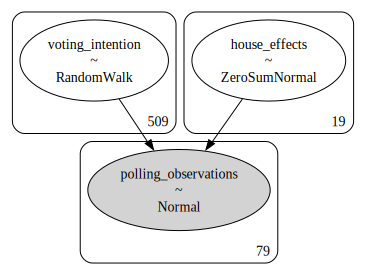

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [voting_intention, house_effects]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 49 seconds.


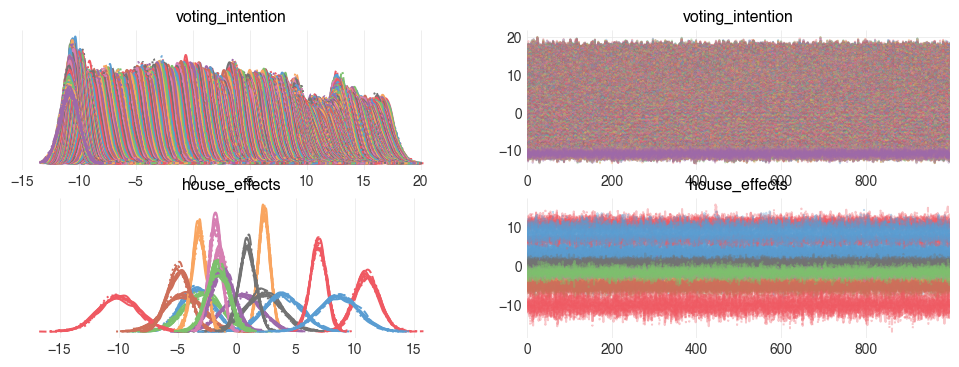

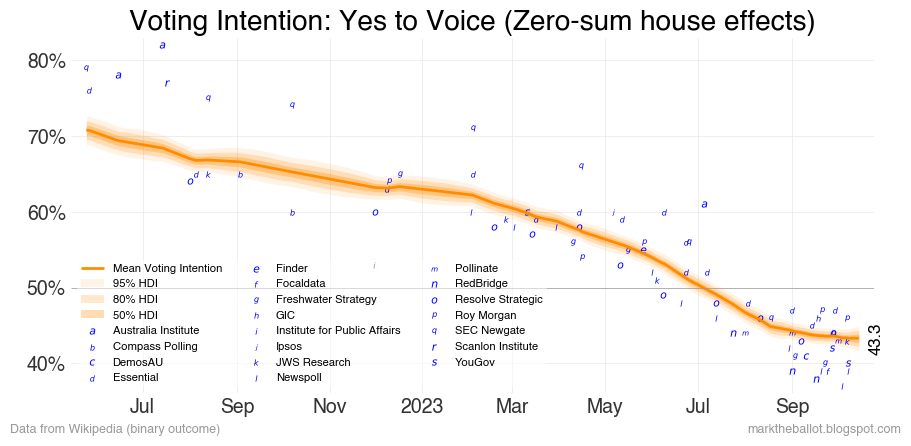

RangeIndex(start=0, stop=19, step=1)


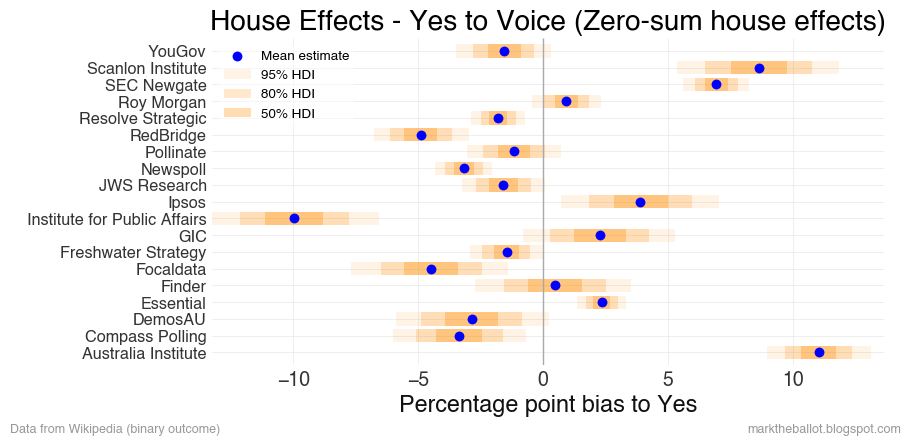

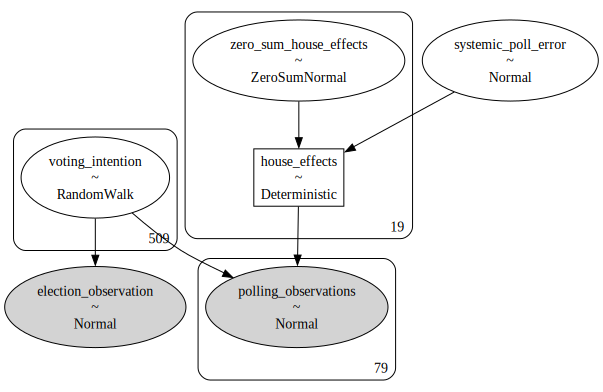

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [voting_intention, systemic_poll_error, zero_sum_house_effects]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 66 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


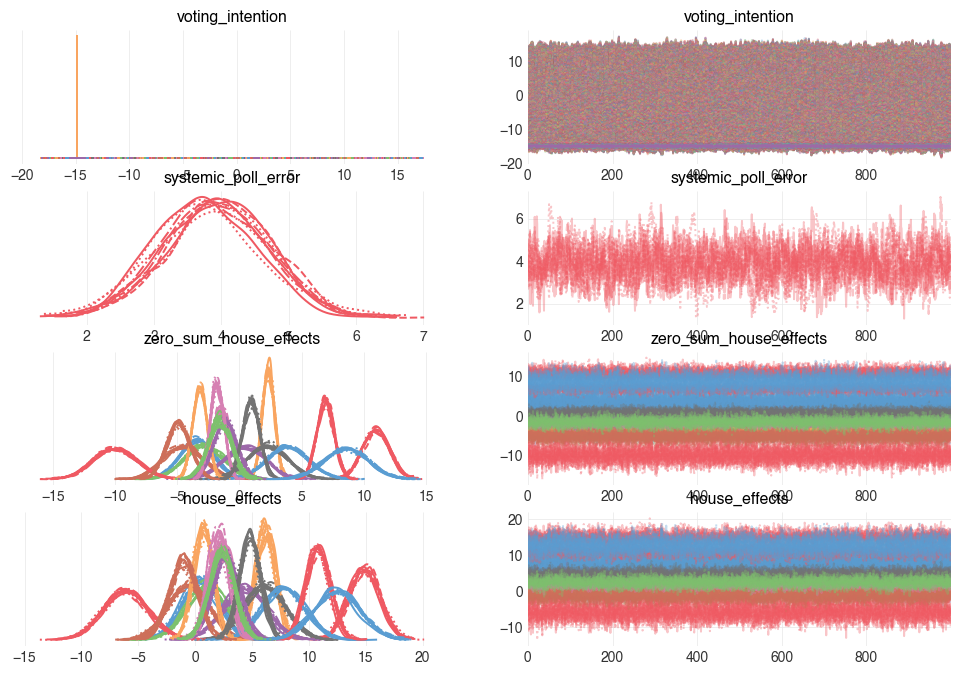

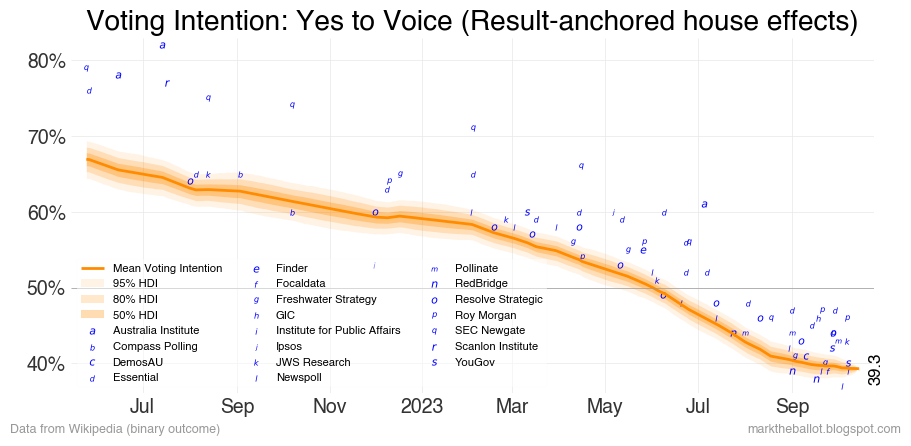

RangeIndex(start=0, stop=19, step=1)


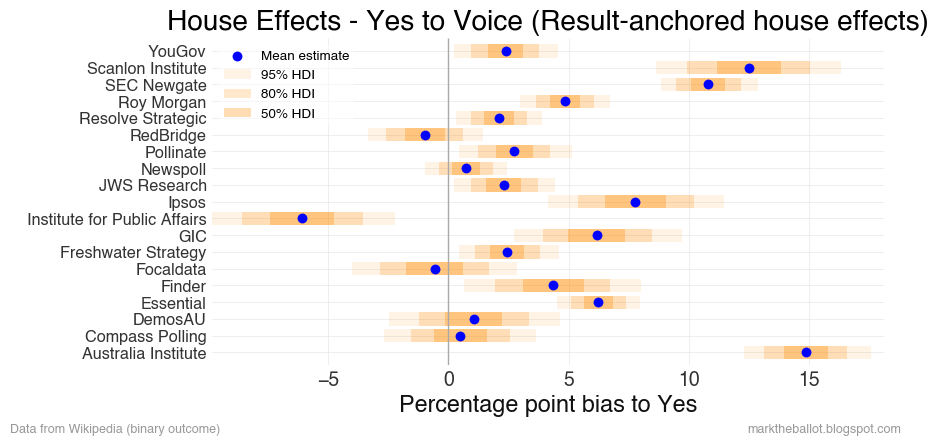

In [14]:
analytic_frame = (
    # [anchor, tag,]
    [
        None,
        "Zero-sum",
    ],
    [
        OFFSET_RESULT,
        "Result-anchored",
    ],
)

for anchor, tag in analytic_frame:
    model = define_model(
        n_firms,
        n_days,
        poll_day,
        poll_firm,
        zero_centered_y,
        measurement_error_sd,
        right_anchor=anchor,
    )

    gv = pm.model_to_graphviz(model)
    gv.render(format="png", filename=f"model-graphviz-{tag}")
    display(gv)

    trace, summary = draw_samples(model)

    plot_aggregation(
        trace,
        recent_data,
        "Yes",
        day_zero,
        n_days,
        centre_offset,
        "blue",
        "darkorange",
        f"Yes to Voice ({tag} house effects)",
    )

    plot_house_effects(
        trace,
        brand_mapping=firm_map,
        title=f"Yes to Voice ({tag} house effects)",
        point_color="blue",
        line_color="darkorange",
    )

## Finished

In [15]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sat Oct 21 2023 13:58:13

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

numpy     : 1.25.2
arviz     : 0.16.1
matplotlib: 3.8.0
pymc      : 5.9.0
pandas    : 2.1.1
re        : 2.2.1

Watermark: 2.4.3



In [16]:
print("Finished")

Finished
